# Random Forest Classifier

## Contents
- [Imports](#Imports)
- [Prepare Dataset](#Prepare-Dataset)
- [OPTION: Cluster Latitude and Longitude data](#OPTION:-Cluster-Latitude-and-Longitude-data)
- [Bootstrap](#Bootstrap)
- [One Hot Encode Features](#One-Hot-Encode-Features)
- [Create Scaled X, y and Train, Test](#Create-Scaled-X,-y-and-Train,-Test)
- [Compile and Fit Random Forest Classifier](#Compile-and-Fit-Random-Forest-Classifier)
- [More Advanced Random Forest Classifier](#More-Advanced-Random-Forest-Classifier)
- [Extract Best Model Features](#Extract-Best-Model-Features)
- [Model Evaluation](#Model-Evaluation)

## Overview
This notebook explores the random forest classifier model. The goal from this model is not to produce the best predictive model, but to extract feature importance. Feature importance is useful to the scope of this project to help understand the situations that lend themselves towards creating wildfires.

#### Top 3 Features:

|Feature|Importance|Feature Description|
|---|---|---|
|tavg_t3m|0.05085|Average Temperature Past 3 Months|
|pcp|0.04720|Month Precipitation|
|tavg_t6m|0.04633|Average Temperature Past 6 Months|

# Imports

In [1]:
# Import libraries.
import boto3
import io
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

s3 = boto3.client('s3')

%config InlineBackend.figure_format = 'retina'

# Prepare Dataset

In [2]:
# Pull in cleaned and combined data from AWS 
noaa_on_fire = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
noaa_on_fire.drop(columns='Unnamed: 0', inplace=True)
noaa_on_fire.dropna(inplace=True)

In [3]:
noaa_on_fire_btstrp.columns

Index(['fire_code', 'fire_name', 'complex_name', 'stat_cause_code',
       'stat_cause_descr', 'fire_size', 'fire_size_class', 'latitude',
       'longitude', 'state', 'fips_code', 'cont_date_fixed', 'disc_date_fixed',
       'time_burnt', 'month', 'year', 'yearmonth', 'pcp', 'tavg', 'pdsi',
       'phdi', 'zndx', 'pmdi', 'cdd', 'hdd', 'sp01', 'sp02', 'sp03', 'sp06',
       'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'tavg_t3m', 'tavg_t6m',
       'tavg_t9m', 'tavg_t12m', 'pcp_t3m', 'pcp_t6m', 'pcp_t9m', 'pcp_t12m',
       'pmdi_t3m', 'pmdi_t6m', 'pmdi_t9m', 'pmdi_t12m', 'pdsi_t3m', 'pdsi_t6m',
       'pdsi_t9m', 'pdsi_t12m'],
      dtype='object')

# OPTION: Cluster Latitude and Longitude data

In [4]:
# # Put lat/long into a matrix
# location_data = round(noaa_on_fire[['longitude', 'latitude']],4) # round to decrease grid accuracy of lat/long

# # Cluster lat/long
# km = KMeans(n_clusters=200)
# km.fit(location_data)

# # Append clusters back into model_df
# noaa_on_fire.loc[:, 'cluster'] = km.predict(location_data)

# Bootstrap

In [ ]:
noaa_on_fire_btstrp = pd.concat([noaa_on_fire, 
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'C'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'D'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'E'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'F'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'G'].sample(n = 100000, replace = True, random_state=11)], axis = 0)

# One Hot Encode Features

In [5]:
noaa_on_fire_btstrp = pd.get_dummies(noaa_on_fire, columns=['state', 'month'], drop_first= True)
#noaa_on_fire = pd.get_dummies(noaa_on_fire, columns=['cluster']) # location clustered by lat/long

# Create Scaled X, y and Train, Test

In [7]:
# Set up X and y variables, and bootstrap data

X = noaa_on_fire_btstrp[[ 'pcp', #3rd_Most_Important_Feature #
                         'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02','sp03', 'sp06', 'sp09', #10
                         'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3','month_4', 'month_5', 'cdd', 'hdd', #20
                         'month_6', 'month_7', 'month_8', 'month_9','month_10', 'month_11', 'month_12', 'tavg_t12m','tavg_t9m', 
                         'tavg_t6m', #2nd_Most_Important_Feature #30
                         'tavg_t3m', #Most_Important_Feature_ #31 
                         'pcp_t12m', 'pcp_t9m', 'pcp_t6m','pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m', #40
                           'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']] #43

y = noaa_on_fire_btstrp['fire_size_class']

# Train Test Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

#Standard Scale data
stan = StandardScaler()
X_train = stan.fit_transform(X_train)
X_test = stan.transform(X_test)

#### Model Baseline

In [9]:
# What is the accuracy of our baseline model?
y.value_counts(normalize=True)

A    0.615586
B    0.272828
C    0.059007
D    0.017875
E    0.014640
F    0.012505
G    0.007558
Name: fire_size_class, dtype: float64

# Compile and Fit Random Forest Classifier

In [43]:
# Instantiate simple RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
# Fit and score on the training data.
cross_val_score(rf, X_train, y_train, cv=5).mean()

In [ ]:
# Score on the testing data.
rf.score(X_test, y_test)

In [ ]:
# Calculate Recall Score on random forest
recall_score(y_train, rf.predict(X_train), average = 'weighted')

In [ ]:
# Plot random forest confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');

# More Advanced Random Forest Classifier

In [ ]:
# instantiate Validation Curve to evaluate estimators of the models
num_est=[100, 200, 300]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3,
                                n_jobs=-1)

In [ ]:
# Instantiate Random Forest Classifier 
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  
                                  min_samples_leaf = 1, 
                                  n_jobs=-1) 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

importance = modelVC.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Gridsearch to find best parameters. It will take a while to run!

In [15]:
# # Set up parameters to grid search over - Keep Me!
# n_estimators = [100, 300, 500]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 50]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_train, y_train)

In [16]:
# # List best features score
# bestF.best_score_

In [17]:
# # List best parameters
# bestF.best_params_

# Extract Best Model Features

Feature: 0, Score: 0.04720
Feature: 1, Score: 0.02558
Feature: 2, Score: 0.02324
Feature: 3, Score: 0.01834
Feature: 4, Score: 0.03848
Feature: 5, Score: 0.02124
Feature: 6, Score: 0.02542
Feature: 7, Score: 0.02554
Feature: 8, Score: 0.02111
Feature: 9, Score: 0.02555
Feature: 10, Score: 0.02735
Feature: 11, Score: 0.02810
Feature: 12, Score: 0.03935
Feature: 13, Score: 0.02445
Feature: 14, Score: 0.00078
Feature: 15, Score: 0.00252
Feature: 16, Score: 0.00289
Feature: 17, Score: 0.00254
Feature: 18, Score: 0.03166
Feature: 19, Score: 0.02632
Feature: 20, Score: 0.00351
Feature: 21, Score: 0.00163
Feature: 22, Score: 0.00202
Feature: 23, Score: 0.00156
Feature: 24, Score: 0.00096
Feature: 25, Score: 0.00097
Feature: 26, Score: 0.00064
Feature: 27, Score: 0.04107
Feature: 28, Score: 0.03528
Feature: 29, Score: 0.04633
Feature: 30, Score: 0.05085
Feature: 31, Score: 0.04034
Feature: 32, Score: 0.03549
Feature: 33, Score: 0.03198
Feature: 34, Score: 0.03091
Feature: 35, Score: 0.03593
Fe

AttributeError: 'BarContainer' object has no attribute 'show'

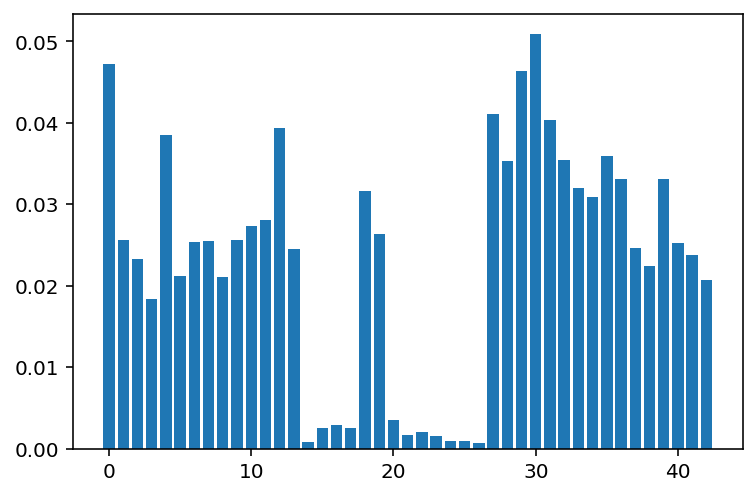

In [12]:
# Run the model with the best params from the grid search
forestOpt = RandomForestClassifier(random_state = 11, max_depth = 15, n_estimators = 100, min_samples_split = 10, min_samples_leaf = 10, n_jobs=-1)                             
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

importance = modelOpt.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
feature_importance = pyplot.bar([x for x in range(len(importance))], importance)
feature_importance.show()

# Model Evaluation

In [19]:
# List recall score
recall_score(y_train, modelOpt.predict(X_train), average = 'weighted')

0.6255511881721503

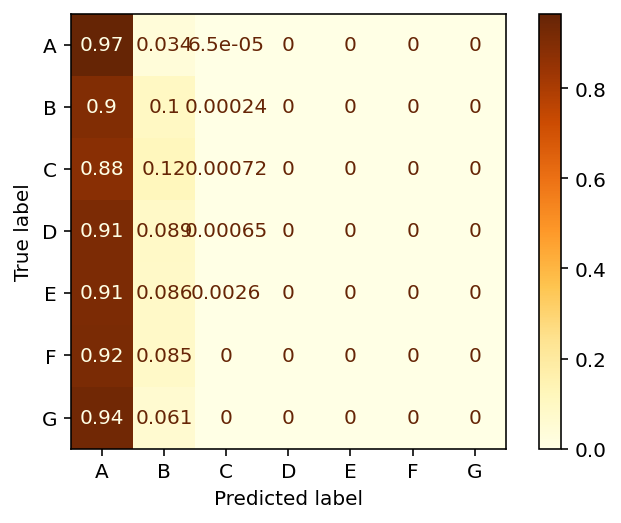

In [20]:
# Plot a confusion matrix
plot_confusion_matrix(modelOpt, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');